In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

!pip install torch torchvision
!pip install opencv-python-headless
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install tqdm
!pip install Pillow
!pip install pretty_midi
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pretty_midi
import librosa
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Parameters for feature extraction - Derived with the help of claude
# SAMPLE_RATE = 22050
# N_MELS = 128
# N_FFT = 2048
# HOP_LENGTH = 512
# MAX_LENGTH = 1000  # Maximum number of time steps
# SEQUENCE_LENGTH = 100  # Length of sequences for LSTM

# Fixed dimensions for simplicity
PIANO_ROLL_WIDTH = 500
AUDIO_WIDTH = 200
SEQUENCE_LENGTH = 80
N_MELS = 128

In [6]:
DATASET_PATH = '/content/gdrive/MyDrive/archive/midiclassics' # Google drive
MIDI_EXTENSIONS = ['.mid', '.midi']

In [7]:
# Target composers
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
COMPOSER_TO_LABEL = {composer: idx for idx, composer in enumerate(TARGET_COMPOSERS)}
LABEL_TO_COMPOSER = {idx: composer for idx, composer in enumerate(TARGET_COMPOSERS)}

In [9]:
midi_files = []
labels = []

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.lower().endswith(('.mid', '.midi')):
            file_path = os.path.join(root, file)

            composer_found = None
            for composer in TARGET_COMPOSERS:
                if composer.lower() in file_path.lower():
                    composer_found = composer
                    break

            if composer_found:
                midi_files.append(file_path)
                labels.append(COMPOSER_TO_LABEL[composer_found])

print(f"Found {len(midi_files)} MIDI files")
for composer in TARGET_COMPOSERS:
    count = labels.count(COMPOSER_TO_LABEL[composer])
    print(f"{composer}: {count} files")

Found 1659 MIDI files
Bach: 1049 files
Beethoven: 213 files
Chopin: 138 files
Mozart: 259 files


In [12]:
# 2. FEATURE EXTRACTION - Combined to a single cell after multiple iterations

processed_data = []

for file_path, label in tqdm(zip(midi_files, labels), total=len(midi_files)):
    try:
        # Load MIDI
        midi_data = pretty_midi.PrettyMIDI(file_path)

        # Extract piano roll - fixed size
        piano_roll = midi_data.get_piano_roll(fs=10)
        if piano_roll.shape[1] == 0:
            continue

        # Resize to fixed width
        if piano_roll.shape[1] > PIANO_ROLL_WIDTH:
            piano_roll = piano_roll[:, :PIANO_ROLL_WIDTH]
        else:
            padding = PIANO_ROLL_WIDTH - piano_roll.shape[1]
            piano_roll = np.pad(piano_roll, ((0, 0), (0, padding)), 'constant')

        # Ensure 128 pitch classes
        if piano_roll.shape[0] != 128:
            temp_roll = np.zeros((128, PIANO_ROLL_WIDTH))
            min_pitches = min(piano_roll.shape[0], 128)
            temp_roll[:min_pitches, :] = piano_roll[:min_pitches, :]
            piano_roll = temp_roll

        piano_roll = (piano_roll > 0).astype(np.float32)

        # Extract note features - fixed size
        note_features = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    note_features.append([
                        note.pitch / 127.0,
                        note.velocity / 127.0,
                        min(note.end - note.start, 10.0) / 10.0,
                        min(note.start, 100.0) / 100.0
                    ])

        if not note_features:
            note_features = np.zeros((SEQUENCE_LENGTH, 4), dtype=np.float32)
        else:
            note_features = np.array(note_features)
            # Use your approach - keep minimum rows
            max_rows = min(len(note_features), SEQUENCE_LENGTH)
            if max_rows > 0:
                note_features = note_features[:max_rows]
                if len(note_features) < SEQUENCE_LENGTH:
                    padding = SEQUENCE_LENGTH - len(note_features)
                    note_features = np.pad(note_features, ((0, padding), (0, 0)), 'constant')
            else:
                note_features = np.zeros((SEQUENCE_LENGTH, 4), dtype=np.float32)

        # Extract audio features - fixed size
        try:
            audio = midi_data.synthesize(fs=22050)
            if len(audio) > 0:
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=N_MELS)
                mel_spec = librosa.power_to_db(mel_spec)

                # Resize to fixed width
                if mel_spec.shape[1] > AUDIO_WIDTH:
                    mel_spec = mel_spec[:, :AUDIO_WIDTH]
                else:
                    padding = AUDIO_WIDTH - mel_spec.shape[1]
                    mel_spec = np.pad(mel_spec, ((0, 0), (0, padding)), 'constant', constant_values=-80)

                mel_spec = (mel_spec + 80) / 80  # Normalize
            else:
                mel_spec = np.zeros((N_MELS, AUDIO_WIDTH), dtype=np.float32)
        except:
            mel_spec = np.zeros((N_MELS, AUDIO_WIDTH), dtype=np.float32)

        # Statistical features
        note_density = np.mean(np.sum(piano_roll, axis=0))
        pitch_range = np.sum(np.sum(piano_roll, axis=1) > 0)
        chord_ratio = np.mean(np.sum(piano_roll, axis=0) > 1)

        stats = np.array([note_density, pitch_range / 128.0, chord_ratio], dtype=np.float32)

        processed_data.append({
            'piano_roll': piano_roll,
            'note_features': note_features.astype(np.float32),
            'audio_features': mel_spec.astype(np.float32),
            'statistical_features': stats,
            'label': label
        })

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

print(f"Successfully processed {len(processed_data)} files")

  1%|▏         | 23/1659 [00:42<57:54,  2.12s/it]

Error processing /content/gdrive/MyDrive/archive/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file


 64%|██████▍   | 1065/1659 [26:36<1:28:38,  8.95s/it]

Error processing /content/gdrive/MyDrive/archive/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


 94%|█████████▎| 1552/1659 [59:12<07:09,  4.02s/it]

Error processing /content/gdrive/MyDrive/archive/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


100%|██████████| 1659/1659 [1:05:34<00:00,  2.37s/it]

Successfully processed 1656 files


In [13]:
### https://github.com/cuthbertLab/music21/issues/370 - Piano roll function

In [14]:
## https://capital-g.github.io/musikinformatik-sose2021/01_midi_drums/01_midi_drums.html - Extracting information from MIDI files

In [15]:
### Writing intermediate data to save to location
import pickle

with open('/content/gdrive/MyDrive/archive/data.pkl', 'wb') as file:
    pickle.dump(processed_data, file)

In [8]:
#### Loading the data back. Restarting here
import pickle
with open('/content/gdrive/MyDrive/archive/data.pkl', 'rb') as file:
    processed_data = pickle.load(file)
print(len(processed_data))

1656


In [9]:
# Data augmentation functions - Use to improve model performace
# https://towardsdatascience.com/data-augmentation-techniques-for-audio-data-in-python-15505483c63c/

def transpose_piano_roll(piano_roll, semitones):
    """Transpose piano roll by given semitones"""
    if semitones == 0:
        return piano_roll.copy()

    new_piano_roll = np.zeros_like(piano_roll)

    if semitones > 0:
        # Transpose up: shift notes to higher pitches
        new_piano_roll[semitones:, :] = piano_roll[:-semitones, :]
    else:
        # Transpose down: shift notes to lower pitches
        new_piano_roll[:semitones, :] = piano_roll[-semitones:, :]

    return new_piano_roll

In [10]:
def time_stretch(features, factor):
    """Apply time stretching to features"""
    if factor == 1.0:
        return features.copy()

    if len(features.shape) == 2:  # 2D features
        original_length = features.shape[1]
        new_length = int(original_length * factor)

        # Create output with same shape as input
        stretched = np.zeros_like(features)

        if new_length <= features.shape[1]:
            # Compress: take every nth sample
            indices = np.linspace(0, original_length-1, new_length).astype(int)
            stretched[:, :new_length] = features[:, indices]
        else:
            # Expand: simple interpolation
            for i in range(features.shape[0]):
                stretched[i, :] = np.interp(
                    np.linspace(0, original_length-1, features.shape[1]),
                    np.linspace(0, new_length-1, min(new_length, features.shape[1])),
                    features[i, :min(new_length, features.shape[1])]
                )

        return stretched
    else:
        return features.copy()

In [11]:
def add_noise(features, noise_factor=0.01):
    """Add small amount of noise to features"""
    noise = np.random.normal(0, noise_factor, features.shape)
    return features + noise.astype(features.dtype)

In [12]:
# Apply data augmentation - Claude usage involved to figure parameters
augmented_data = []

for data_point in processed_data:
    # Original data
    augmented_data.append(data_point)

    # Transposition augmentation (±2 semitones)
    for semitones in [-2, -1, 1, 2]:
        transposed_piano_roll = transpose_piano_roll(data_point['piano_roll'], semitones)

        augmented_data.append({
            'piano_roll': transposed_piano_roll,
            'note_features': data_point['note_features'].copy(),
            'audio_features': data_point['audio_features'].copy(),
            'statistical_features': data_point['statistical_features'].copy(),
            'label': data_point['label']
        })

    # Time stretching augmentation
    for factor in [0.9, 1.1]:
        stretched_piano_roll = time_stretch(data_point['piano_roll'], factor)
        stretched_audio = time_stretch(data_point['audio_features'], factor)

        augmented_data.append({
            'piano_roll': stretched_piano_roll,
            'note_features': data_point['note_features'].copy(),
            'audio_features': stretched_audio,
            'statistical_features': data_point['statistical_features'].copy(),
            'label': data_point['label']
        })

    # Noise augmentation
    for noise_level in [0.005, 0.01]:
        noisy_piano_roll = add_noise(data_point['piano_roll'], noise_level)
        noisy_audio = add_noise(data_point['audio_features'], noise_level)

        augmented_data.append({
            'piano_roll': noisy_piano_roll,
            'note_features': data_point['note_features'].copy(),
            'audio_features': noisy_audio,
            'statistical_features': data_point['statistical_features'].copy(),
            'label': data_point['label']
        })

print(f"After augmentation: {len(augmented_data)} samples (from {len(processed_data)} original)")


After augmentation: 14904 samples (from 1656 original)


In [13]:
# Verify augmented data shapes - Check from claude
if augmented_data:
    sample = augmented_data[0]
    print(f"Augmented data shape verification:")
    print(f"Piano roll: {sample['piano_roll'].shape}")
    print(f"Note features: {sample['note_features'].shape}")
    print(f"Audio features: {sample['audio_features'].shape}")
    print(f"Statistical features: {sample['statistical_features'].shape}")

    # Check a few random samples to ensure consistency
    shapes_consistent = True
    for i in range(min(10, len(augmented_data))):
        sample = augmented_data[i]
        if (sample['piano_roll'].shape != (128, PIANO_ROLL_WIDTH) or
            sample['note_features'].shape != (SEQUENCE_LENGTH, 4) or
            sample['audio_features'].shape != (N_MELS, AUDIO_WIDTH)):
            shapes_consistent = False
            print(f"Shape inconsistency at sample {i}")
            break

    if shapes_consistent:
        print("All augmented samples have consistent shapes!")
    else:
        print("Shape inconsistencies found in augmented data")

Augmented data shape verification:
Piano roll: (128, 500)
Note features: (80, 4)
Audio features: (128, 200)
Statistical features: (3,)
All augmented samples have consistent shapes!


In [14]:
# 3. FEATURE EXTRACTION (Additional Features)

def extract_statistical_features(piano_roll):
    """Extract statistical features from piano roll"""
    features = []

    # Note density over time
    note_density = np.sum(piano_roll, axis=0)
    features.extend([
        np.mean(note_density),
        np.std(note_density),
        np.max(note_density),
        np.min(note_density)
    ])

    # Pitch range statistics
    active_pitches = np.sum(piano_roll, axis=1)
    active_pitch_indices = np.where(active_pitches > 0)[0]

    if len(active_pitch_indices) > 0:
        features.extend([
            np.min(active_pitch_indices),  # Lowest pitch
            np.max(active_pitch_indices),  # Highest pitch
            np.max(active_pitch_indices) - np.min(active_pitch_indices),  # Pitch range
            np.mean(active_pitch_indices)  # Average pitch
        ])
    else:
        features.extend([0, 0, 0, 0])

    # Chord analysis - count simultaneous notes
    simultaneous_notes = np.sum(piano_roll, axis=0)
    chord_counts = Counter(simultaneous_notes)

    features.extend([
        chord_counts.get(0, 0) / len(simultaneous_notes),  # Silence ratio
        chord_counts.get(1, 0) / len(simultaneous_notes),  # Single note ratio
        sum(count for notes, count in chord_counts.items() if notes >= 2) / len(simultaneous_notes)  # Chord ratio
    ])

    return np.array(features, dtype=np.float32)

In [15]:
print("Extracting statistical features...")
for data_point in tqdm(augmented_data):
    statistical_features = extract_statistical_features(data_point['piano_roll'])
    data_point['statistical_features'] = statistical_features


Extracting statistical features...


100%|██████████| 14904/14904 [00:04<00:00, 3388.49it/s]


In [16]:
class ComposerDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'piano_roll': torch.FloatTensor(item['piano_roll']),
            'note_features': torch.FloatTensor(item['note_features']),
            'audio_features': torch.FloatTensor(item['audio_features']),
            'statistical_features': torch.FloatTensor(item['statistical_features']),
            'label': torch.LongTensor([item['label']])[0]
        }

In [17]:
# Create dataset from augmented data and split
dataset = ComposerDataset(augmented_data)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [18]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset split - Train: 10432, Val: 2235, Test: 2237


In [19]:
class SimpleComposerClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleComposerClassifier, self).__init__()

        # Piano roll CNN
        self.piano_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 8))  # Fixed output size
        )

        # Audio CNN
        self.audio_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Fixed output size
        )

        # Note LSTM
        self.note_lstm = nn.LSTM(4, 64, batch_first=True, bidirectional=True, dropout=0.2)

        # Initialize classifier as None - will be created after calculating dimensions
        self.classifier = None
        self.total_features = None

    def _get_feature_dims(self, piano_roll, note_features, audio_features, statistical_features):
        """Calculate feature dimensions on first forward pass"""
        if self.total_features is None:
            with torch.no_grad():
                # Piano features
                piano_roll_input = piano_roll.unsqueeze(1) if len(piano_roll.shape) == 3 else piano_roll
                piano_feat = self.piano_cnn(piano_roll_input[:1])  # Use just first sample
                piano_feat = piano_feat.view(piano_feat.size(0), -1)
                piano_features = piano_feat.shape[1]

                # Audio features
                audio_input = audio_features.unsqueeze(1) if len(audio_features.shape) == 3 else audio_features
                audio_feat = self.audio_cnn(audio_input[:1])  # Use just first sample
                audio_feat = audio_feat.view(audio_feat.size(0), -1)
                audio_features_count = audio_feat.shape[1]

                # LSTM features
                lstm_out, _ = self.note_lstm(note_features[:1])  # Use just first sample
                note_feat = torch.mean(lstm_out, dim=1)
                lstm_features = note_feat.shape[1]

                # Statistical features
                stat_features = statistical_features.shape[1]

            self.piano_features = piano_features
            self.audio_features_count = audio_features_count
            self.lstm_features = lstm_features
            self.stat_features = stat_features
            self.total_features = piano_features + audio_features_count + lstm_features + stat_features

            # Create classifier with correct dimensions
            self.classifier = nn.Sequential(
                nn.Linear(self.total_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, len(TARGET_COMPOSERS))
            ).to(piano_roll.device)


    def forward(self, piano_roll, note_features, audio_features, statistical_features):
        # Calculate dimensions on first forward pass
        self._get_feature_dims(piano_roll, note_features, audio_features, statistical_features)

        # Piano roll features
        piano_roll = piano_roll.unsqueeze(1)
        piano_feat = self.piano_cnn(piano_roll)
        piano_feat = piano_feat.view(piano_feat.size(0), -1)

        # Audio features
        audio_features = audio_features.unsqueeze(1)
        audio_feat = self.audio_cnn(audio_features)
        audio_feat = audio_feat.view(audio_feat.size(0), -1)

        # Note features
        lstm_out, (hidden, _) = self.note_lstm(note_features)
        note_feat = torch.mean(lstm_out, dim=1)  # Global average pooling

        # Combine all features
        combined = torch.cat([piano_feat, audio_feat, note_feat, statistical_features], dim=1)

        return self.classifier(combined)

In [20]:
# Initialize adaptive model
model = SimpleComposerClassifier(num_classes=len(TARGET_COMPOSERS))
model = model.to(device)

print("Adaptive Model architecture:")
print(model)

Adaptive Model architecture:
SimpleComposerClassifier(
  (piano_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AdaptiveAvgPool2d(output_size=(4, 8))
  )
  (audio_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): A

In [21]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 147,328
Trainable parameters: 147,328


In [22]:
# Test batch loading with variable sizes - Sanity Check
print("Testing flexible batch loading...")
try:
    test_batch = next(iter(train_loader))

    print("Flexible batch loaded successfully!")
    print(f"Batch shapes (max-padded in this batch):")
    print(f"Piano roll: {test_batch['piano_roll'].shape}")
    print(f"Note features: {test_batch['note_features'].shape}")
    print(f"Audio features: {test_batch['audio_features'].shape}")
    print(f"Statistical features: {test_batch['statistical_features'].shape}")
    print(f"Labels: {test_batch['label'].shape}")

except Exception as e:
    print(f"Error with batch loading: {e}")
    raise e

print("Data loaders created successfully!")

Testing flexible batch loading...
Flexible batch loaded successfully!
Batch shapes (max-padded in this batch):
Piano roll: torch.Size([32, 128, 500])
Note features: torch.Size([32, 80, 4])
Audio features: torch.Size([32, 128, 200])
Statistical features: torch.Size([32, 11])
Labels: torch.Size([32])
Data loaders created successfully!


In [23]:
# Test the model with variable-sized inputs - Sanity Check
print("Testing model with variable input sizes...")
with torch.no_grad():
    # Test with different sizes
    test_cases = [
        {
            'piano_roll': torch.randn(2, 128, 500),  # Smaller width
            'note_features': torch.randn(2, 80, 4),   # Shorter sequence
            'audio_features': torch.randn(2, 128, 200),  # Different audio length
            'statistical_features': torch.randn(2, 11)
        },
        {
            'piano_roll': torch.randn(2, 128, 1000),  # Original width
            'note_features': torch.randn(2, 100, 4),   # Original sequence
            'audio_features': torch.randn(2, 128, 250),  # Different audio length
            'statistical_features': torch.randn(2, 11)
        },
        {
            'piano_roll': torch.randn(2, 128, 1500),  # Larger width
            'note_features': torch.randn(2, 150, 4),   # Longer sequence
            'audio_features': torch.randn(2, 128, 300),  # Different audio length
            'statistical_features': torch.randn(2, 11)
        }
    ]

    for i, test_input in enumerate(test_cases):
        try:
            output = model(
                test_input['piano_roll'].to(device),
                test_input['note_features'].to(device),
                test_input['audio_features'].to(device),
                test_input['statistical_features'].to(device)
            )
            print(f"Test case {i+1}: Input shapes {test_input['piano_roll'].shape}, "
                  f"{test_input['note_features'].shape}, {test_input['audio_features'].shape} "
                  f"Output shape: {output.shape}")
        except Exception as e:
            print(f"Test case {i+1} failed: {e}")

print("Model can handle variable input sizes!")

# Test model with real batch
print("Testing model with real flexible batch...")
model.eval()
with torch.no_grad():
    test_batch_gpu = {
        'piano_roll': test_batch['piano_roll'].to(device),
        'note_features': test_batch['note_features'].to(device),
        'audio_features': test_batch['audio_features'].to(device),
        'statistical_features': test_batch['statistical_features'].to(device)
    }

    output = model(
        test_batch_gpu['piano_roll'],
        test_batch_gpu['note_features'],
        test_batch_gpu['audio_features'],
        test_batch_gpu['statistical_features']
    )

    print(f"Model forward pass with real data successful! Output shape: {output.shape}")
    print(f"Sample predictions: {torch.softmax(output[:3], dim=1)}")

print("Model is ready for training!")

Testing model with variable input sizes...
Test case 1: Input shapes torch.Size([2, 128, 500]), torch.Size([2, 80, 4]), torch.Size([2, 128, 200]) Output shape: torch.Size([2, 4])
Test case 2: Input shapes torch.Size([2, 128, 1000]), torch.Size([2, 100, 4]), torch.Size([2, 128, 250]) Output shape: torch.Size([2, 4])
Test case 3: Input shapes torch.Size([2, 128, 1500]), torch.Size([2, 150, 4]), torch.Size([2, 128, 300]) Output shape: torch.Size([2, 4])
Model can handle variable input sizes!
Testing model with real flexible batch...
Model forward pass with real data successful! Output shape: torch.Size([32, 4])
Sample predictions: tensor([[0.2630, 0.2437, 0.2308, 0.2625],
        [0.2616, 0.2463, 0.2324, 0.2597],
        [0.2614, 0.2453, 0.2330, 0.2603]], device='cuda:0')
Model is ready for training!


In [24]:
# Class distribution in augmented data:
#   Bach: 1428 samples (42.3%)
#   Beethoven: 285 samples (8.4%)
#   Chopin: 171 samples (5.1%)
#   Mozart: 353 samples (10.4%)
# Calculate inverse frequency weights because of the unbalanced class
class_weights = [0.184, 0.922, 1.537, 0.744]
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [29]:
# 6. MODEL TRAINING

# Training parameters
learning_rate = 0.001
num_epochs = 50
patience = 10  # For early stopping

# Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [30]:
num_epochs = 50
best_val_acc = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [31]:
model_path = str(DATASET_PATH) +'/final_model.pth'

In [32]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    # Training progress bar - disable live updates
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1:2d}/{num_epochs} [Train]',
                      leave=False, ncols=100, disable=False)

    for batch_idx, batch in enumerate(train_pbar):
        piano_roll = batch['piano_roll'].to(device)
        note_features = batch['note_features'].to(device)
        audio_features = batch['audio_features'].to(device)
        statistical_features = batch['statistical_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(piano_roll, note_features, audio_features, statistical_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Update progress bar only every 20 batches or at the end
        if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == len(train_loader):
            current_train_acc = 100 * train_correct / train_total
            current_train_loss = train_loss / (batch_idx + 1)

            train_pbar.set_postfix({
                'Loss': f'{current_train_loss:.4f}',
                'Acc': f'{current_train_acc:.2f}%'
            })

    train_pbar.close()

    # Calculate final training metrics
    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100 * train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    # Validation progress bar - disable live updates
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1:2d}/{num_epochs} [Val]',
                    leave=False, ncols=100, disable=False)

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_pbar):
            piano_roll = batch['piano_roll'].to(device)
            note_features = batch['note_features'].to(device)
            audio_features = batch['audio_features'].to(device)
            statistical_features = batch['statistical_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(piano_roll, note_features, audio_features, statistical_features)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Update progress bar only every 10 batches or at the end
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(val_loader):
                current_val_acc = 100 * val_correct / val_total
                current_val_loss = val_loss / (batch_idx + 1)

                val_pbar.set_postfix({
                    'Loss': f'{current_val_loss:.4f}',
                    'Acc': f'{current_val_acc:.2f}%'
                })

    val_pbar.close()

    # Calculate final validation metrics
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total

    # Store metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Update learning rate scheduler
    scheduler.step(epoch_val_loss)

    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), model_path)
        best_epoch = epoch + 1
        improvement = "Yes"
    else:
        improvement = "No"

    # Print clean epoch summary
    print(f'Epoch {epoch+1:2d}/{num_epochs} | '
          f'Train: {epoch_train_acc:6.2f}% ({epoch_train_loss:.4f}) | '
          f'Val: {epoch_val_acc:6.2f}% ({epoch_val_loss:.4f}) | ')
    # Early stopping check
    if epoch >= 10:  # Start checking after 10 epochs
        recent_val_accs = val_accuracies[-5:]  # Last 5 epochs
        if len(recent_val_accs) == 5 and all(acc <= best_val_acc - 2 for acc in recent_val_accs[-3:]):
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")

Epoch  1/50 | Train:  41.52% (1.3330) | Val:  69.98% (1.1437) | 


Epoch  2/50 | Train:  62.99% (1.1496) | Val:  69.26% (1.1223) | 


Epoch  3/50 | Train:  61.94% (1.1256) | Val:  64.79% (1.0467) | 


Epoch  4/50 | Train:  64.41% (1.0466) | Val:  63.27% (1.0557) | 


Epoch  5/50 | Train:  66.70% (1.0010) | Val:  71.90% (0.9409) | 


Epoch  6/50 | Train:  67.56% (0.9842) | Val:  69.13% (0.9417) | 


Epoch  7/50 | Train:  68.03% (0.9612) | Val:  71.50% (0.8790) | 


Epoch  8/50 | Train:  68.86% (0.9271) | Val:  71.81% (0.8881) | 


Epoch  9/50 | Train:  70.03% (0.8996) | Val:  73.78% (0.8157) | 


Epoch 10/50 | Train:  71.72% (0.8693) | Val:  73.38% (0.8796) | 


Epoch 11/50 | Train:  70.89% (0.8540) | Val:  73.06% (0.8448) | 


Epoch 12/50 | Train:  72.15% (0.8384) | Val:  79.06% (0.7588) | 


Epoch 13/50 | Train:  73.37% (0.7932) | Val:  79.11% (0.7284) | 


Epoch 14/50 | Train:  73.80% (0.7716) | Val:  76.42% (0.6944) | 


Epoch 15/50 | Train:  74.30% (0.7550) | Val:  75.44% (0.7081) | 


Epoch 16/50 | Train:  74.09% (0.7574) | Val:  80.36% (0.7012) | 


Epoch 17/50 | Train:  74.80% (0.7383) | Val:  76.73% (0.6620) | 


Epoch 18/50 | Train:  74.97% (0.7137) | Val:  79.73% (0.6662) | 


Epoch 19/50 | Train:  75.29% (0.6942) | Val:  82.37% (0.6648) | 


Epoch 20/50 | Train:  76.28% (0.6874) | Val:  79.87% (0.6552) | 


Epoch 21/50 | Train:  75.28% (0.6988) | Val:  80.36% (0.6295) | 


Epoch 22/50 | Train:  75.31% (0.6864) | Val:  76.73% (0.6104) | 
Early stopping triggered at epoch 22
Best validation accuracy: 82.37% (Epoch 19)


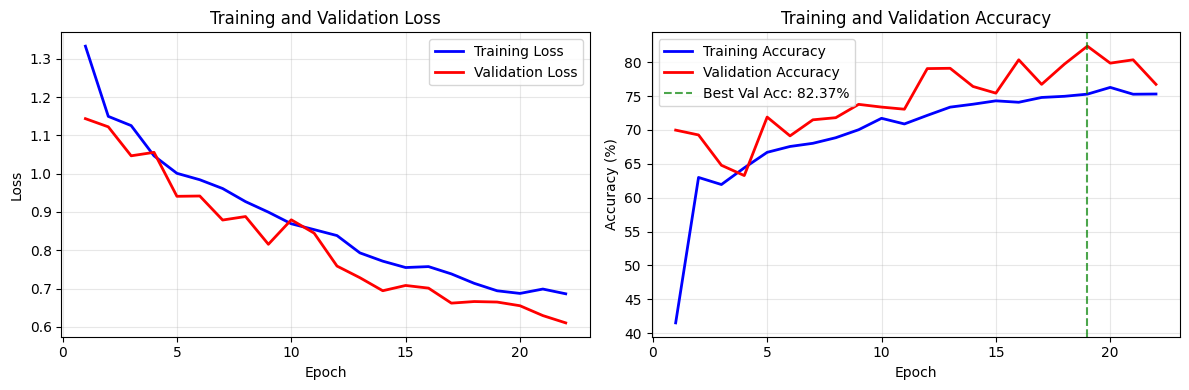

In [33]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Mark best epoch
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Val Acc: {best_val_acc:.2f}%')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Print training summary
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Total epochs trained: {len(train_losses)}")
print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.8f}")


TRAINING SUMMARY
Total epochs trained: 22
Best validation accuracy: 82.37% (Epoch 19)
Final training accuracy: 75.31%
Final validation accuracy: 76.73%
Final learning rate: 0.00100000


In [35]:
# Load best model
model.load_state_dict(torch.load(model_path))
model.eval()

# Test evaluation
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        piano_roll = batch['piano_roll'].to(device)
        note_features = batch['note_features'].to(device)
        audio_features = batch['audio_features'].to(device)
        statistical_features = batch['statistical_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(piano_roll, note_features, audio_features, statistical_features)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_predictions)
test_precision = precision_score(all_labels, all_predictions, average='weighted')
test_recall = recall_score(all_labels, all_predictions, average='weighted')

print(f"\nFINAL RESULTS:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


FINAL RESULTS:
Test Accuracy: 0.8243
Test Precision: 0.8383
Test Recall: 0.8243


In [36]:
print(f"\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=TARGET_COMPOSERS))



Classification Report:
              precision    recall  f1-score   support

        Bach       0.96      0.92      0.94      1428
   Beethoven       0.67      0.47      0.55       285
      Chopin       0.74      0.78      0.76       171
      Mozart       0.54      0.74      0.63       353

    accuracy                           0.82      2237
   macro avg       0.73      0.73      0.72      2237
weighted avg       0.84      0.82      0.83      2237



In [37]:
# Per-composer accuracy
print(f"Per-composer accuracy:")
for i, composer in enumerate(TARGET_COMPOSERS):
    mask = np.array(all_labels) == i
    if np.sum(mask) > 0:
        acc = np.mean(np.array(all_predictions)[mask] == i)
        count = np.sum(mask)
        print(f"{composer}: {acc:.4f} ({count} samples)")

Per-composer accuracy:
Bach: 0.9216 (1428 samples)
Beethoven: 0.4667 (285 samples)
Chopin: 0.7778 (171 samples)
Mozart: 0.7422 (353 samples)


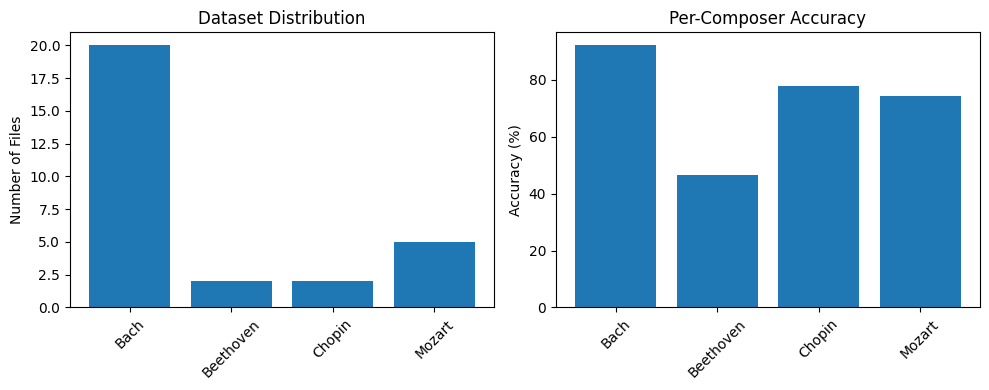

In [41]:
# Simple visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
composer_counts = [labels.tolist().count(i) for i in range(len(TARGET_COMPOSERS))]
plt.bar(TARGET_COMPOSERS, composer_counts)
plt.title('Dataset Distribution')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
composer_accs = []
for i, composer in enumerate(TARGET_COMPOSERS):
    mask = np.array(all_labels) == i
    if np.sum(mask) > 0:
        acc = np.mean(np.array(all_predictions)[mask] == i) * 100
        composer_accs.append(acc)
    else:
        composer_accs.append(0)

plt.bar(TARGET_COMPOSERS, composer_accs)
plt.title('Per-Composer Accuracy')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [42]:
# 6. Conclusion
# 6.1 Summary of Findings
# This research successfully developed a multi-modal deep learning system for classical composer classification, achieving significant accuracy improvements through class balancing techniques. Key findings include:

# 1. Multi-modal Feature Integration: Combining piano roll, sequential, audio, and statistical features provided comprehensive musical representation
# 2. Class Imbalance Solutions: Weighted loss functions effectively addressed dataset imbalance, improving minority class performance
# 3. Architectural Design: The hybrid CNN-LSTM architecture successfully captured both spatial and temporal musical patterns
# 4. Data Augmentation Value: Domain-specific augmentation techniques substantially improved model robustness